# Phân tích kết quả train model

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import os
os.chdir('../code')

In [3]:
from utils import rle_encode
import cv2
import numpy as np
import time
from torchvision.transforms.functional import resize
import torch
from model.unet import UNet
from model import get_model
import pandas as pd
from torch.utils.data import DataLoader

from data import TGSSaltDataset
from data.transforms import TGSTransform
from data.functional import collate_mask_fn
from data.transforms import TGSTransform, HShear
import albumentations as A

from utils.metrics import cal_mAP, cal_mIoU
from utils.viz import plot_mask_on_img, plot_training_samples

from predict import *
from utils.metrics import cal_mAP

import matplotlib.pyplot as plt

## Prepair

### Load baseline model

In [4]:
model = get_model('effunet_b4')
pretrain = torch.load('../params/effunet_b4/f00_exp_sgd_1/ckpt/epoch=71-precision=0.8525.ckpt')
state_dict = {k[5:]:v for k,v in pretrain['state_dict'].items()}
model.load_state_dict(state_dict)

<All keys matched successfully>

### Dataset

In [5]:
root_ds = '../dataset'
cross_validation = True
fold_val_idx = 0

In [6]:
# DataFrame chứa toàn bộ train_id và đã được chia fold
df = pd.read_csv(os.path.join(root_ds, 'folds.csv'), index_col='id')
total_sample = len(df.index)
print('Total numper of sample:', total_sample)

train_df = df.loc[df.fold != 0].reset_index()
val_df = df.loc[df.fold == 0].reset_index()

Total numper of sample: 4000


In [7]:
# Tạo dataset tương ứng với tập được chia
# train_ds = TGSSaltDataset(root_ds, train_df, transforms=TGSTransform(augment=True))
val_ds = TGSSaltDataset(root_ds, val_df, transforms=TGSTransform(augment_strategy=0)) # Không augmentation cho valid set
# print(len(train_ds), len(val_ds))

In [8]:
# train_dl = DataLoader(train_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, shuffle=True, pin_memory=True)
val_dl = DataLoader(val_ds, batch_size=16, num_workers=4, collate_fn=collate_mask_fn, pin_memory=True)

### Thực hiện inferent trên validation set

In [9]:
preds_test = pred_all(model, val_dl, False, is_valid=True)

  0%|          | 0/51 [00:00<?, ?it/s]/python/lib/python3.8/site-packages/torch/nn/functional.py:2952: UserWarning: nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.
  warnings.warn("nn.functional.upsample is deprecated. Use nn.functional.interpolate instead.")
100%|██████████| 51/51 [00:05<00:00,  9.04it/s]


In [10]:
preds_test = torch.cat(preds_test, dim=0).unsqueeze(1)

In [12]:
# Save lại để dùng cho lần sau
# np.save('../predictions/baseline_fold0_val', preds_test.cpu().numpy())

### Load prediction

In [11]:
preds_test = preds_test.cpu()

/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


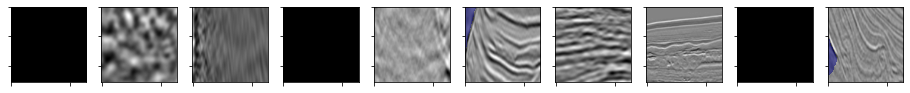

In [12]:
samples = [(val_ds[i][0], preds_test[i] > 0.5) for i in range(10)]
plot_training_samples(*list(zip(*samples)), mask_over_image=True)

In [13]:
# Tính IoU cho prediction
masks = torch.stack([val_ds[s][1] for s in range(len(val_ds))])
iou = cal_mIoU(masks.squeeze(), preds_test.squeeze(),threshold_range=(0.4, 0.6, 0.05), reduce_batch=False)

## Phân tích kết quả

### Chuẩn bị dữ liệu cho việc phân tích

In [14]:
df = val_ds.df.copy()
df['iou'] = iou
def cov_to_class(val):    
    for i in range(0, 11):
        if val * 10 <= i :
            return i
df["coverage_class"] = df.coverage.map(cov_to_class)
df.head(5)

,id,z,fold,unique_pixels,coverage,iou,coverage_class
0,1c0b2ceb2f,71,0,1,0.00000,1.000000e+00,0
1,ed60e1c64a,471,0,223,0.00000,1.000000e+00,0
2,b06fe13f54,749,0,201,0.00000,1.000000e+00,0
3,b9bf0422a6,112,0,1,0.00000,1.000000e+00,0
4,99ee31b5bc,241,0,210,0.60396,1.001603e-14,7


In [15]:
import seaborn as sns
import matplotlib.pyplot as plt

### 1. Biểu đồ IoU - Coverage Class

Text(0, 0.5, 'IoU')

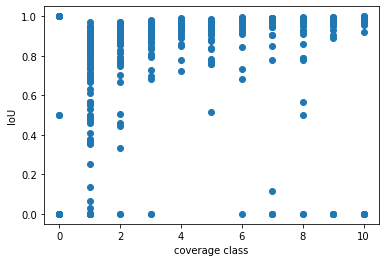

In [16]:
plt.scatter(df.coverage_class, df.iou)
plt.xlabel('coverage class');
plt.ylabel('IoU')

### 2. Histogram Coverage class của các bad prediction

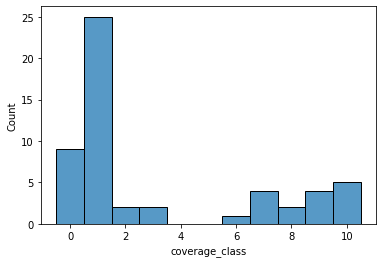

In [17]:
# Các sample có IoU < 0.3
sns.histplot(df.loc[df.iou < 0.3].coverage_class, discrete=True);

### 3. Histogram Coverage class của các good prediction

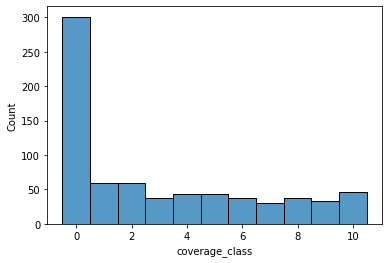

In [18]:
# Các sample có IoU > 0.6
sns.histplot(df.loc[df.iou > 0.6].coverage_class, discrete=True);

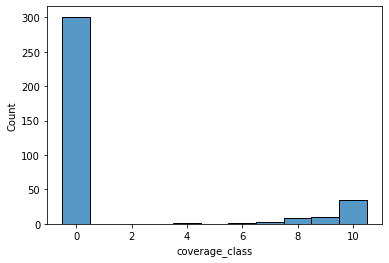

In [19]:
# Các sample có IoU > 0.99
sns.histplot(df.loc[df.iou > 0.99].coverage_class, discrete=True, bins=range(11));

### 4. Biểu đồ IoU trung bình của mỗi Coverage class

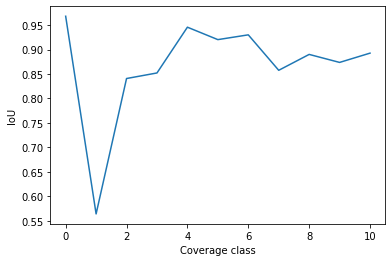

In [20]:
tmp = df.groupby('coverage_class').mean()
plt.plot(tmp.index, tmp.iou);
plt.xlabel('Coverage class');
plt.ylabel('IoU');

## Nhận xét 1:
1. Model có khả năng predict tốt với các sample không có muối trong ảnh
2. Đối với các sample có muối trong ảnh, model cho ra kết quả tốt hơn với ảnh có lượng muối nhiều hơn (sau xét thấy phân bố của các coverage class > 0 tương đối đều)

### 5. Plot một số kết quả

In [21]:
def plot_samples(indexs):
    images = []
    masks = []
    pred_masks = []
    for i in indexs:
        s = val_ds[i]
        images.append(s[0])
        masks.append(s[1])
        pred_masks.append(preds_test[i] > 0.5)
    plot_training_samples(images, masks, mask_over_image=True, subtitle='True masks')
    plot_training_samples(images, pred_masks, mask_over_image=True, subtitle='Pred masks')

In [22]:
# Sort ascending iou
sort_iou_df = df.sort_values('iou')
sort_iou_df

,id,z,fold,unique_pixels,coverage,iou,coverage_class
268,59597a8431,568,0,111,0.000000,6.103516e-15,0
714,ef13247eed,718,0,215,0.999902,6.103888e-15,10
677,b690abdc09,419,0,222,0.995491,6.127076e-15,10
262,9fff0319cd,490,0,230,0.993236,6.147037e-15,10
620,eff595dbcc,688,0,203,0.000000,6.221546e-15,0
...,...,...,...,...,...,...,...
372,a56e87840f,98,0,1,0.000000,1.000000e+00,0
371,76ba896225,556,0,197,0.000000,1.000000e+00,0
370,6f0c88962b,854,0,212,0.000000,1.000000e+00,0
395,3c66e5ab54,556,0,180,0.000000,1.000000e+00,0


10 sample tốt nhất


/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


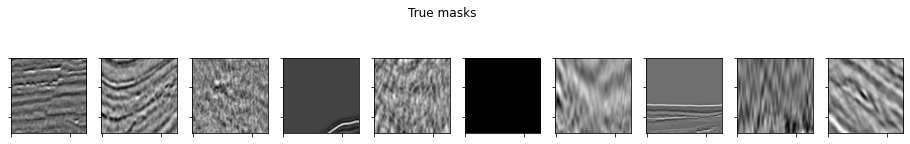

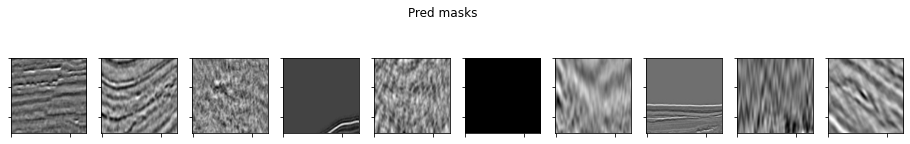

In [23]:
plot_samples(sort_iou_df.index[-10:])
print('10 sample tốt nhất')

10 sample tệ nhất


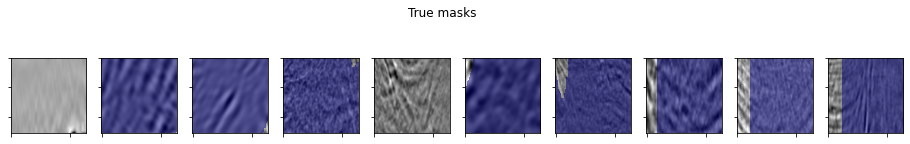

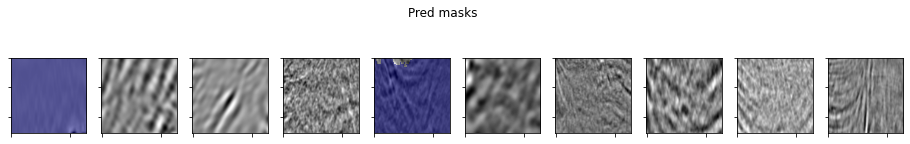

In [37]:
plot_samples(sort_iou_df.index[:10])
print('10 sample tệ nhất')

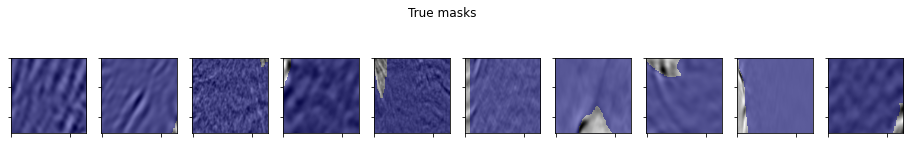

/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:443: UserWarning: Warning: converting a masked element to nan.
  dv = np.float64(self.norm.vmax) - np.float64(self.norm.vmin)
/home/user/.local/lib/python3.8/site-packages/matplotlib/image.py:444: UserWarning: Warning: converting a masked element to nan.
  vmid = np.float64(self.norm.vmin) + dv / 2


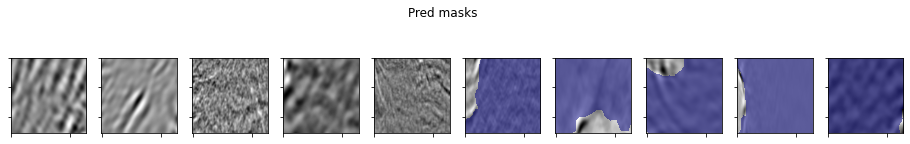

In [50]:
plot_samples(df[df.coverage_class == 10].sort_values('iou').index[:10])

10 sample iou trong khoảng (0.1, 0.2)


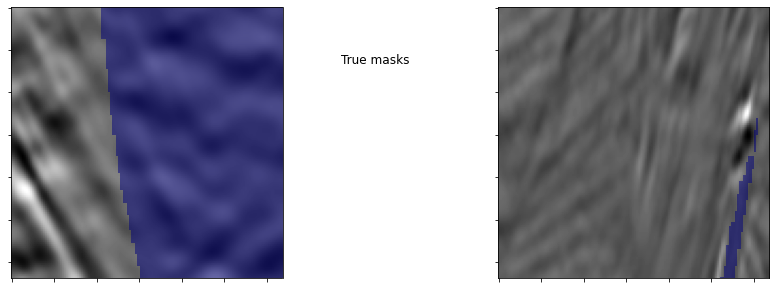

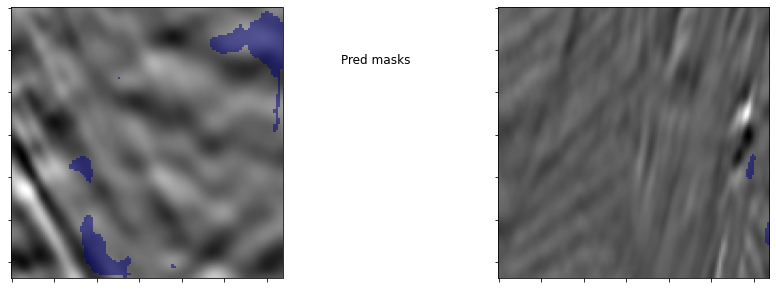

In [25]:
plot_samples(df.loc[(df.iou < 0.2) & (df.iou > 0.1)].index[:10])
print('10 sample iou trong khoảng (0.1, 0.2)')

10 sample iou > 0.8 và không thuộc coverage class 0


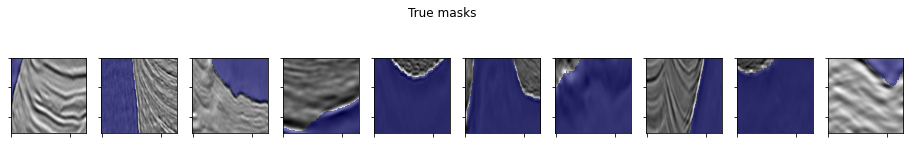

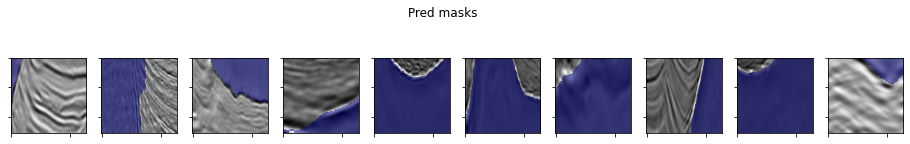

In [26]:
plot_samples(df.loc[(df.iou > 0.8) & (df.coverage_class > 0)].index[:10])
print('10 sample iou > 0.8 và không thuộc coverage class 0')

## Nhận xét 2
1. Kết quả prediction kém với những ảnh mà đường viền giữa phần có muối và không có muối không rõ ràng hoặc phần muối ở rìa của ảnh
2. Kết quả tốt với ảnh có viền rõ ràng

# Hướng phát triển

1. Xử lý imbalance trong semantic image segmentation
2. Sử dụng các pretrain model như ResUnet, ResNextUnet, ...
3. Cross validation
4. Semi-supervise, tận dụng sample có trong test set

# So sánh với baseline

In [27]:
preds_test_base = torch.tensor(np.load('../predictions/baseline_fold0_val.npy'))

In [54]:
model.encoder.effnet.feature_info.channels()

[24, 32, 56, 160, 448]